# Applied Data Science Capstone Project
Using historical data to analyse and estimate road accident severity.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

In [2]:
# Decide whether to do dimensionality reduction
do_dimensionality_reduction = True
if (do_dimensionality_reduction):
    feature_set_limit = 24 # topmost features by order of descending importances
else:
    feature_set_limit = 5

# Use Seatle Department of Transport Data
This data was downloaded directly from the website (<a href="https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d"></a> as the sample shared in the course was missing critical attributes such as *'INJURIES'*.<p/>
A preliminary cleaning of the data is done to prepare the data set that is somewhat similar to the sample in course.

In [3]:
filename = 'Collisions.csv'
collisions_loaded = pd.read_csv(filename)
print('Shape:', collisions_loaded.shape)
collisions_loaded.head(2)

Shape: (221144, 40)


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1280915.029,197717.5345,1,29800,29800,1177964,Unmatched,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,...,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N
1,NaN,NaN,2,115700,115700,10097005,Unmatched,NaN,NaN,NaN,...,NaN,NaN,NaN,10097005.0,NaN,NaN,NaN,0,0,N


In [4]:
collisions_loaded = collisions_loaded.dropna(axis=0, subset=['X', 'Y', 'SEVERITYCODE'], how='any')
collisions_loaded.shape

(213674, 40)

In [5]:
# make collisions below 2 considered not severe and above severe
collisions_loaded['SEVERITYCODE'] = collisions_loaded['SEVERITYCODE'].replace(['0', '1', '2', '2b', '3'], ['0', '0', '1', '1', '1'])
collisions_loaded['SEVERITYCODE'] = collisions_loaded['SEVERITYCODE'].astype(int)

In [6]:
collisions_loaded.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [7]:
collisions_loaded.reset_index(inplace=True)
collisions_loaded = collisions_loaded[['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
       'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR']]

In [8]:
out_filename = 'Prepared-Collisions.csv'
collisions_loaded.to_csv(out_filename)

### Now, use the newly prepared dataset:

In [9]:
filename = 'Prepared-Collisions.csv'
collisions_loaded = pd.read_csv(filename)
collisions_loaded.head()

C:\Anaconda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12,36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,0,1280915.029,197717.5345,1,29800,29800,1177964,Unmatched,Block,NaN,...,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N
1,1,1265803.499,269008.0502,3,1358,1358,3568600,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
2,2,1274388.698,229235.9509,4,70700,70700,2806057,Matched,Block,NaN,...,Dry,Other,NaN,7065007.0,NaN,32,One parked--one moving,0,0,N
3,3,1263093.464,200192.5349,5,53600,53600,2127310,Matched,Block,NaN,...,Dry,Daylight,NaN,6137017.0,NaN,14,From same direction - both going straight - on...,0,0,N
4,4,1256925.333,209863.6627,6,1197,1197,3553269,Matched,Intersection,31893.0,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N


In [10]:
collisions_loaded.rename(columns={'SEVERITYCODE': 'severity'}, inplace=True)
collisions_loaded['severity'] = collisions_loaded['severity'].astype(int)
collisions_loaded.columns

Index(['Unnamed: 0', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'severity', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
       'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR'],
      dtype='object')

### Copy loaded data for convenience

In [11]:
collisions_df = collisions_loaded[['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'severity', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
       'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR']].copy()
collisions_df.shape

(213674, 40)

In [12]:
collisions_df.head(2)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1280915.029,197717.5345,1,29800,29800,1177964,Unmatched,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,...,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N
1,1265803.499,269008.0502,3,1358,1358,3568600,Matched,Block,NaN,GREENWOOD AVE N BETWEEN N 134TH ST AND N 136TH ST,...,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N


## Clean Data

In [13]:
print('Loaded data dimensions (shape)', collisions_df.shape)
collisions_df.dtypes

Loaded data dimensions (shape) (213674, 40)


X                  float64
Y                  float64
OBJECTID             int64
INCKEY               int64
COLDETKEY            int64
REPORTNO            object
STATUS              object
ADDRTYPE            object
INTKEY             float64
LOCATION            object
EXCEPTRSNCODE       object
EXCEPTRSNDESC       object
severity             int32
SEVERITYDESC        object
COLLISIONTYPE       object
PERSONCOUNT          int64
PEDCOUNT             int64
PEDCYLCOUNT          int64
VEHCOUNT             int64
INJURIES             int64
SERIOUSINJURIES      int64
FATALITIES           int64
INCDATE             object
INCDTTM             object
JUNCTIONTYPE        object
SDOT_COLCODE       float64
SDOT_COLDESC        object
INATTENTIONIND      object
UNDERINFL           object
WEATHER             object
ROADCOND            object
LIGHTCOND           object
PEDROWNOTGRNT       object
SDOTCOLNUM         float64
SPEEDING            object
ST_COLCODE          object
ST_COLDESC          object
S

### Item: SEVERITYCODE
This code corresponds to the severity of the collision. Only two codes are represented in the data ***(1=property damage and 2=injury)***. This code can be used as the target labels for the purpose of machine learning (ML). The redundundant SEVERITYCODE.1 should be dropped.
<p/>

### Item: X, Y
These are coordinates, ***where X=longitude (magnitudes<180) and Y=latitude (magnitudes<90)*** - these can be renamed used instead of the **LOCATION**, which is a description of the general location of the collision. So LOCATION should be dropped.
<p/>

### Initial List of Reduncant Items: (***based on insights drawn from the metadata document***)
OBJECTID, INCKEY, COLDETKEY, REPORTNO, INTKEY, EXCEPTRSNCODE, EXCEPTRSNDESC, SEVERITYDESC (***deferred***), INCDATE (***prefer INCDTTM***), SDOT_COLDESC, ST_COLDESC

In [14]:
#colns_to_drop = ['Unnamed: 0', 'LOCATION', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'INTKEY', 'EXCEPTRSNCODE',\
#                 'EXCEPTRSNDESC', 'SEVERITYDESC', 'INCDATE', 'SDOT_COLDESC', 'ST_COLDESC']
#collisions_df.drop(columns=colns_to_drop, inplace=True)

In [15]:
collisions_df.rename(columns={'X': 'longitude', 'Y': 'latitude'}, inplace=True)
collisions_df.head(1)

,longitude,latitude,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1280915.029,197717.5345,1,29800,29800,1177964,Unmatched,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,...,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N


# Business Understanding
The objective is to leverage the accident data set provided to predict the different accidents' severity (the target label). The data set provides only two classes of severity (property damage=1, injury=2) as indicated by the SEVERITYCODE column. This is therefore, a binary classification problem.<p/>
Clearly, there are implications for predicting the severity class of each collision (either injury or property damage). The assumption is that an injury from a collision will indicate that the any medical assistance team will need to come prepared to possibly safe lifes or at least improve the chances of survival. The emergency team must come prepared to improve survival rates - and they may need to ask preparatory questions in preparation as they approach the collision location, etc. Therefore, false negatives (for the injury class) could have major implications. A false positive simply means that the emergency team would come prepared for injury that in all likelihood does did not actually occur - the cost implications for this scenary presumably are much lower and can be considered manageable.<p/>
On the other hand, the issue of property damage may not have such life-threatening implications compared to collision injury.

### Revisit the column data types

In [16]:
collisions_df.dtypes

longitude          float64
latitude           float64
OBJECTID             int64
INCKEY               int64
COLDETKEY            int64
REPORTNO            object
STATUS              object
ADDRTYPE            object
INTKEY             float64
LOCATION            object
EXCEPTRSNCODE       object
EXCEPTRSNDESC       object
severity             int32
SEVERITYDESC        object
COLLISIONTYPE       object
PERSONCOUNT          int64
PEDCOUNT             int64
PEDCYLCOUNT          int64
VEHCOUNT             int64
INJURIES             int64
SERIOUSINJURIES      int64
FATALITIES           int64
INCDATE             object
INCDTTM             object
JUNCTIONTYPE        object
SDOT_COLCODE       float64
SDOT_COLDESC        object
INATTENTIONIND      object
UNDERINFL           object
WEATHER             object
ROADCOND            object
LIGHTCOND           object
PEDROWNOTGRNT       object
SDOTCOLNUM         float64
SPEEDING            object
ST_COLCODE          object
ST_COLDESC          object
S

<hr color= "red"/> 

### Data Visualization and Pre-processing
Based on the target labels, let’s see how many of each class are in the data set (is it balanced or unbalanced)

In [17]:
collisions_df['severity'].value_counts()

0    152696
1     60978
Name: severity, dtype: int64

**Summary:**<br/>
    136485 collisions are property damage (1) and 58188 (injury) ==> the class distribution is unbalanced. ***The classifier performance will be better evaluated with the F1-Score metric instead of accuracy, as it is the harmonic mean of the recall and precision***.<p/>
    According to the following article, <a href="https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2">Accuracy vs. F1-Score</a> by Purva Huilgol, there are critical differences between accuracy and F1-Score:<br/>
    -- Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial<br/>
    -- Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case<br/>
    -- In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on<br/>

Plot some columns to get a better understanding of the data set:

### Convert to date time object 

In [18]:
collisions_df['INCDTTM'] = pd.to_datetime(collisions_df['INCDTTM'])
collisions_df['INCDTTM'].head()

0   2004-11-10 00:00:00
1   2013-04-02 15:10:00
2   2007-03-06 00:00:00
3   2006-05-17 16:56:00
4   2013-03-30 09:43:00
Name: INCDTTM, dtype: datetime64[ns]

### Lets look at the hour of the day that collisions occur
Will need to do some feature engineering to improve the predictability of the models.

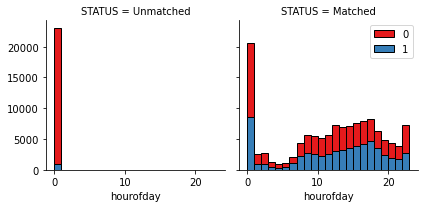

In [19]:
collisions_df['hourofday'] = collisions_df['INCDTTM'].dt.hour
bins = np.linspace(collisions_df.hourofday.min(), collisions_df.hourofday.max(), 24)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'hourofday', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It appears that there is an unusual volume of collisions in the first hour of the day. So we can use feature binarization to set a threshold value less than hour 12 or morning hours. But more generally, the collisions and injuries increase during the day through the afternoon - so it depends on the time of the day.

In [20]:
morning_threshold = 12
collisions_df['morning'] = collisions_df['hourofday'].apply(lambda x: 1 if (x>morning_threshold)  else 0)
collisions_df[['INCDTTM', 'hourofday', 'morning']].head()

,INCDTTM,hourofday,morning
0,2004-11-10 00:00:00,0,0
1,2013-04-02 15:10:00,15,1
2,2007-03-06 00:00:00,0,0
3,2006-05-17 16:56:00,16,1
4,2013-03-30 09:43:00,9,0


<hr color= "red"/> 

### Lets look at collisions with injuries (*INJURIES*)

Bins:  [ 0.          8.66666667 17.33333333 26.         34.66666667 43.33333333
 52.         60.66666667 69.33333333 78.        ]


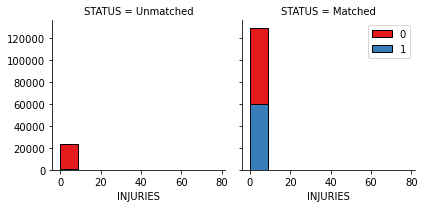

In [21]:
bins = np.linspace(collisions_df.INJURIES.min(), collisions_df.INJURIES.max(), 10)
print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'INJURIES', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Injuries are largely below 10 (all above 10 are considered 10 or above)

In [22]:
collisions_df['INJURIES'] = collisions_df['INJURIES'].apply(lambda x: x if (x<10) else 10)

In [23]:
collisions_df['INJURIES'] = collisions_df['INJURIES'].apply(lambda x: np.digitize(x, bins))
collisions_df['INJURIES'].head()

0    1
1    1
2    1
3    1
4    1
Name: INJURIES, dtype: int64

### Lets look at collisions with serious injuries (*SERIOUSINJURIES*)

Bins:  [ 0.   10.25 20.5  30.75 41.  ]


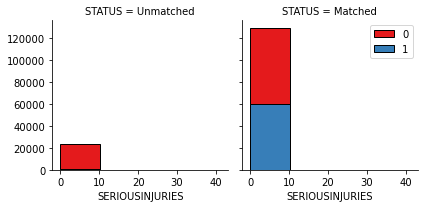

In [24]:
bins = np.linspace(collisions_df.SERIOUSINJURIES.min(), collisions_df.SERIOUSINJURIES.max(), 5)
print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'SERIOUSINJURIES', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Serious injuries are largely below 5 (all above 5 are considered 5 or above)

In [25]:
collisions_df['SERIOUSINJURIES'] = collisions_df['SERIOUSINJURIES'].apply(lambda x: x if (x<5) else 5)

In [26]:
collisions_df['SERIOUSINJURIES'] = collisions_df['SERIOUSINJURIES'].apply(lambda x: np.digitize(x, bins))
collisions_df['SERIOUSINJURIES'].head()

0    1
1    1
2    1
3    1
4    1
Name: SERIOUSINJURIES, dtype: int64

### Lets look at collisions with fatalities (*FATALITIES*)

Bins:  [0.   1.25 2.5  3.75 5.  ]


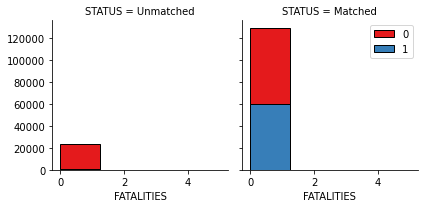

In [27]:
bins = np.linspace(collisions_df.FATALITIES.min(), collisions_df.FATALITIES.max(), 5)
print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'FATALITIES', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Serious injuries are largely below 2 (all above 2 are considered 2 or above)

In [28]:
collisions_df['FATALITIES'] = collisions_df['FATALITIES'].apply(lambda x: x if (x<2) else 2)

In [29]:
collisions_df['FATALITIES'] = collisions_df['FATALITIES'].apply(lambda x: np.digitize(x, bins))
collisions_df['FATALITIES'].head()

0    1
1    1
2    1
3    1
4    1
Name: FATALITIES, dtype: int64

## Convert Categorical features to numerical values

Lets look at collision status:
*Matched possibly refers to matched pairs or collisions involving two vehicles, see this study in the <a href="https://academic.oup.com/aje/article/167/5/546/211795">American Journal of Epidemiology</a>.*

In [30]:
collisions_df.groupby(['STATUS'])['severity'].value_counts(normalize=True)

STATUS     severity
Matched    0           0.683555
           1           0.316445
Unmatched  0           0.958786
           1           0.041214
Name: severity, dtype: float64

30% of matched collisions result in injury compared to 21% of unmatched collisions - not a huge difference but significant

Lets convert matched to 0 and unmatched to 1:

In [31]:
collisions_df['STATUS'].replace(to_replace=['Matched','Unmatched'], value=[0, 1],inplace=True)

Lets look at inattention: *(reasonable default seems to be 'N')*

In [32]:
# first replace all missing data with 'N' - seems a reasonable default
collisions_df['INATTENTIONIND'].fillna('N', inplace=True)
collisions_df['INATTENTIONIND'].replace(to_replace=['N','Y'], value=[0, 1],inplace=True)

In [33]:
collisions_df.groupby(['INATTENTIONIND'])['severity'].value_counts(normalize=True)

INATTENTIONIND  severity
0               0           0.726335
                1           0.273665
1               0           0.641636
                1           0.358364
Name: severity, dtype: float64

In 35% of collisions inattention = Y result in injury, compared to 29% where inattention = N.<br/>

Lets look at under the influence: *(0=N, 1=Y)*

In [34]:
# first replace all missing data with 'N' or 0 - seems a reasonable default
collisions_df['UNDERINFL'].fillna('N', inplace=True)
collisions_df['UNDERINFL'].replace(to_replace=['0', '1','N','Y'], value=[0, 1, 0, 1],inplace=True)
collisions_df['UNDERINFL'] = collisions_df['UNDERINFL'].astype(int)

In [35]:
collisions_df.groupby(['UNDERINFL'])['severity'].value_counts(normalize=True)

UNDERINFL  severity
0          0           0.720981
           1           0.279019
1          0           0.576045
           1           0.423955
Name: severity, dtype: float64

In 39% of collisions with driver under the influence resulted in injury, compared to 29% with driver not under the influence.<br/>

Lets look at speeding: *(0=N, 1=Y)*

In [36]:
# first replace all missing data with 'N' or 0 - seems a reasonable default
collisions_df['SPEEDING'].fillna('N', inplace=True)
collisions_df['SPEEDING'].replace(to_replace=['N','Y'], value=[0, 1],inplace=True)
collisions_df['SPEEDING'] = collisions_df['SPEEDING'].astype(int)

In [37]:
collisions_df.groupby(['SPEEDING'])['severity'].value_counts(normalize=True)

SPEEDING  severity
0         0           0.720330
          1           0.279670
1         0           0.588926
          1           0.411074
Name: severity, dtype: float64

In 38% of collisions with driver speeding resulted in injury, compared to 29% with driver not speeding.<br/>

<hr color= "red"/> 

At this point, check the status of the dataframe:

In [38]:
collisions_df.head()

,longitude,latitude,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,hourofday,morning
0,1280915.029,197717.5345,1,29800,29800,1177964,1,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,...,NaN,4315006.0,0,NaN,NaN,0,0,N,0,0
1,1265803.499,269008.0502,3,1358,1358,3568600,0,Block,NaN,GREENWOOD AVE N BETWEEN N 134TH ST AND N 136TH ST,...,NaN,NaN,0,28,From opposite direction - one left turn - one ...,0,0,N,15,1
2,1274388.698,229235.9509,4,70700,70700,2806057,0,Block,NaN,E DENNY WAY BETWEEN 11TH AVE AND 12TH AVE,...,NaN,7065007.0,0,32,One parked--one moving,0,0,N,0,0
3,1263093.464,200192.5349,5,53600,53600,2127310,0,Block,NaN,DELRIDGE WAY SW BETWEEN SW MYRTLE ST AND SW OR...,...,NaN,6137017.0,0,14,From same direction - both going straight - on...,0,0,N,16,1
4,1256925.333,209863.6627,6,1197,1197,3553269,0,Intersection,31893.0,CALIFORNIA AVE SW AND SW GENESEE ST,...,NaN,NaN,0,10,Entering at angle,0,0,N,9,0


<hr color= "red"/> 

## One Hot Encoding  
#### Lets start with collision type

In [39]:
# make sure all NaN are converted to 'Other'
collisions_df['COLLISIONTYPE'].fillna('Other', inplace=True)
np.array(set(collisions_df['COLLISIONTYPE'].values))

array({'Sideswipe', 'Right Turn', 'Rear Ended', 'Left Turn', 'Angles', 'Cycles', 'Head On', 'Other', 'Pedestrian', 'Parked Car'},
      dtype=object)

In [40]:
collisions_df.groupby(['COLLISIONTYPE'])['severity'].value_counts(normalize=False)
#collisions_df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

COLLISIONTYPE  severity
Angles         0           21068
               1           14176
Cycles         1            5197
               0             672
Head On        0            1152
               1             994
Left Turn      0            8296
               1            5703
Other          0           39827
               1            7428
Parked Car     0           44017
               1            2824
Pedestrian     1            6914
               0             675
Rear Ended     0           18920
               1           14572
Right Turn     0            2333
               1             628
Sideswipe      0           15736
               1            2542
Name: severity, dtype: int64

Lets look at the weather:

In [41]:
# make sure all NaN are converted to 'Other'
collisions_df['WEATHER'].fillna('Other', inplace=True)
np.array(set(collisions_df['WEATHER'].values))

array({'Blowing Snow', 'Snowing', 'Severe Crosswind', 'Partly Cloudy', 'Clear', 'Raining', 'Blowing Sand/Dirt', 'Unknown', 'Overcast', 'Sleet/Hail/Freezing Rain', 'Fog/Smog/Smoke', 'Other'},
      dtype=object)

In [42]:
collisions_df.groupby(['WEATHER'])['severity'].value_counts(normalize=False)

WEATHER                   severity
Blowing Sand/Dirt         0              37
                          1              13
Blowing Snow              1               1
Clear                     0           74280
                          1           37835
Fog/Smog/Smoke            0             370
                          1             191
Other                     0           23985
                          1            1178
Overcast                  0           18729
                          1            9186
Partly Cloudy             0               5
                          1               4
Raining                   0           21345
                          1           11536
Severe Crosswind          0              17
                          1               8
Sleet/Hail/Freezing Rain  0              85
                          1              30
Snowing                   0             728
                          1             178
Unknown                   0           131

Lets look at road conditions:

In [43]:
# make sure all NaN are converted to 'Other'
collisions_df['ROADCOND'].fillna('Other', inplace=True)
np.array(set(collisions_df['ROADCOND'].values))

array({'Oil', 'Snow/Slush', 'Wet', 'Sand/Mud/Dirt', 'Dry', 'Ice', 'Unknown', 'Standing Water', 'Other'},
      dtype=object)

In [44]:
collisions_df.groupby(['ROADCOND'])['severity'].value_counts(normalize=False)

ROADCOND        severity
Dry             0           83361
                1           42299
Ice             0             912
                1             286
Oil             0              33
                1              20
Other           0           23347
                1            1067
Sand/Mud/Dirt   0              44
                1              22
Snow/Slush      0             825
                1             174
Standing Water  0              77
                1              29
Unknown         0           13140
                1             750
Wet             0           30957
                1           16331
Name: severity, dtype: int64

Lets look at light conditions:

In [45]:
# make sure all NaN are converted to 'Other'
collisions_df['LIGHTCOND'].fillna('Other', inplace=True)
np.array(set(collisions_df['LIGHTCOND'].values))

array({'Dark - Street Lights On', 'Dusk', 'Daylight', 'Unknown', 'Dark - Unknown Lighting', 'Dark - No Street Lights', 'Dawn', 'Dark - Street Lights Off', 'Other'},
      dtype=object)

In [46]:
collisions_df.groupby(['LIGHTCOND'])['severity'].value_counts(normalize=False)

LIGHTCOND                 severity
Dark - No Street Lights   0            1139
                          1             348
Dark - Street Lights Off  0             851
                          1             338
Dark - Street Lights On   0           33372
                          1           15453
Dark - Unknown Lighting   0              12
                          1               8
Dawn                      0            1632
                          1             885
Daylight                  0           76386
                          1           40174
Dusk                      0            3889
                          1            2055
Other                     0           23548
                          1            1105
Unknown                   0           11867
                          1             612
Name: severity, dtype: int64

<hr color= "red"/> 

# Combining Latitude/Longitude
Combining latitude/longitude position into single feature using the <a href="https://datascience.stackexchange.com/questions/49553/combining-latitude-longitude-position-into-single-feature">Haversine formula</a>

In [47]:
from math import radians, cos, sin, asin, sqrt

def location(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

Use the location function defined to calculate a single location for each pair of latitude/longitude:

In [48]:
collisions_df['location'] = [location(x, y) for x, y in zip(collisions_df.latitude, collisions_df.longitude)]
collisions_df['location'].head()

0     8875.504599
1     9850.288308
2     9358.710501
3    14977.209594
4    17588.740409
Name: location, dtype: float64

Lets look at the locations that collisions occur:

Bins:  [   87.68812048  2292.11538218  4496.54264387  6700.96990556
  8905.39716725 11109.82442894 13314.25169063 15518.67895232
 17723.10621401 19927.5334757 ]


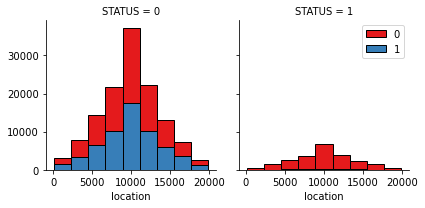

In [49]:
bins = np.linspace(collisions_df.location.min(), collisions_df.location.max(), 10)
print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'location', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions occurred within approximately one standard deviation from a mean point (hot spot).<br/>
We can use feature binarization to set a threshold value about one standard deviation from the hot spot (mean). The bins could be representative of location brackets or locality.

#### First, explore the location partitions or bins or localities:

In [50]:
collisions_df['locality'] = collisions_df['location'].apply(lambda x: np.digitize(x, bins))
collisions_df['locality'].head()

0    4
1    5
2    5
3    7
4    8
Name: locality, dtype: int64

#### Then explore idea of the hot spot as well:

In [51]:
hot_spot = collisions_df.location.mean()
loc_std = collisions_df.location.std()
print('The hot spot is estimated at location [mean =', hot_spot, ',std =', loc_std,']')

The hot spot is estimated at location [mean = 9940.566029365638 ,std = 3741.6002284049778 ]


In [52]:
# binarize location --> point is either within the standard deviation window or not
thres_mult = 1 # i.e. thres_mult * standard deviations from the hot spot
lower_bound = hot_spot - thres_mult*loc_std
upper_bound = hot_spot + thres_mult*loc_std
collisions_df['location'] = collisions_df['location'].apply(lambda x: 1 if (x>lower_bound and x<upper_bound) else 0)
#collisions_df['location'].head()

<hr color= "red"/> 

Lets look at the total number of people involved in collision (PERSONCOUNT):

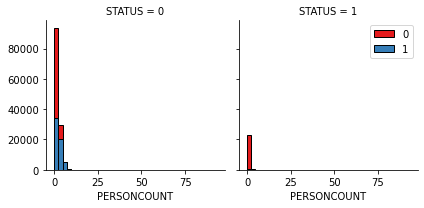

In [53]:
bins = np.linspace(collisions_df.PERSONCOUNT.min(), collisions_df.PERSONCOUNT.max(), 40)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'PERSONCOUNT', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions involving <10 people are associated with most injuries occur.<br/>
We can use feature binarization to set a threshold value of 10.

In [54]:
count_threshold = 10
collisions_df['PERSONCOUNT'] = collisions_df['PERSONCOUNT'].astype(int)
collisions_df['PERSONCOUNT'] = collisions_df['PERSONCOUNT'].apply(lambda x: x if (x<count_threshold)  else 0)
#collisions_df[['PERSONCOUNT']].head()

In [55]:
collisions_df.groupby(['PERSONCOUNT'])['severity'].value_counts(normalize=False)

PERSONCOUNT  severity
0            0           21322
             1            1977
1            0            9435
             1            3447
2            0           86100
             1           29444
3            0           21852
             1           14023
4            0            8257
             1            6506
5            0            3586
             1            3078
6            1            1406
             0            1337
7            1             668
             0             481
8            1             292
             0             245
9            1             137
             0              81
Name: severity, dtype: int64

In 27% of collisions with <4 people resulted in injury, compared to 45% with 4 or more people.<br/>

Lets look at the total number of pedestrians involved in collision (PEDCOUNT):

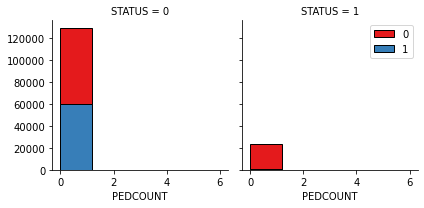

In [56]:
bins = np.linspace(collisions_df.PEDCOUNT.min(), collisions_df.PEDCOUNT.max(), 6)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'PEDCOUNT', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions with <2 pedestrians is where most injuries occur.<br/>
We can use feature binarization to set a threshold value of 2. We must ignore all those with zero pedestrians.

In [57]:
count_threshold = 2
# ignore all with zero pedestrians
collisions_df['PEDCOUNT'] = collisions_df['PEDCOUNT'].apply(lambda x: 1 if (x<count_threshold and x>0)  else 0)
#collisions_df[['PEDCOUNT']].tail(20)

In [58]:
collisions_df.groupby(['PEDCOUNT'])['severity'].value_counts(normalize=False)

PEDCOUNT  severity
0         0           152014
          1            53982
1         1             6996
          0              682
Name: severity, dtype: int64

In 10% of collisions involving pedestrians resulted in injury, compared to 27% without.<br/>

Lets look at the total number of bicycles involved in collision (PEDCYLCOUNT):

In [59]:
# either a bicycle was involved or not
collisions_df['PEDCYLCOUNT'] = collisions_df['PEDCYLCOUNT'].apply(lambda x: 1 if (x>0)  else 0)

Lets look at the total number of vehicles involved in collision (VEHCOUNT):

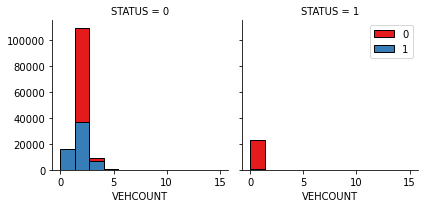

In [60]:
bins = np.linspace(collisions_df.VEHCOUNT.min(), collisions_df.VEHCOUNT.max(), 12)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'VEHCOUNT', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [61]:
# either two vehicles were involved or not
collisions_df['VEHCOUNT'] = collisions_df['VEHCOUNT'].apply(lambda x: x if (x < 5)  else 0)

In [62]:
collisions_df.groupby(['VEHCOUNT'])['severity'].value_counts(normalize=False)

VEHCOUNT  severity
0         0            23581
          1             1619
1         1            15693
          0            10901
2         0           109421
          1            36930
3         0             7456
          1             5604
4         0             1337
          1             1132
Name: severity, dtype: int64

The vast majority of collisions involved two vehicles, with 24% of collisions involving 2 vehicles resulting in injury, compared to 47% otherwise.<br/>

Lets look at the state collision code associated with the collision (SDOT_COLCODE):

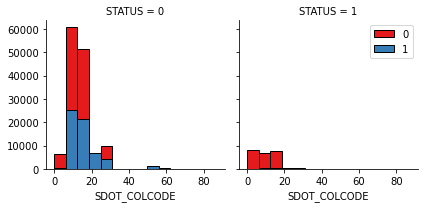

In [63]:
bins = np.linspace(collisions_df.SDOT_COLCODE.min(), collisions_df.SDOT_COLCODE.max(), 15)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'SDOT_COLCODE', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It appears that most collisions are associated with codes between 10 and 15 and most injuries match that range (entering at an angle etc.).

In [64]:
# either two vehicles were involved or not
collisions_df['SDOT_COLCODE'] = collisions_df['SDOT_COLCODE'].apply(lambda x: x if (x >= 10 and x<=30)  else 0)

In [65]:
collisions_df.groupby(['SDOT_COLCODE'])['severity'].value_counts(normalize=False)

SDOT_COLCODE  severity
0.0           0           15124
              1            2401
11.0          0           65643
              1           25494
12.0          0            1707
              1              27
13.0          0            6559
              1             212
14.0          0           40152
              1           17832
15.0          0            1723
              1              78
16.0          0           10052
              1             704
18.0          1            2974
              0             436
21.0          1             161
              0              44
22.0          1              16
              0               2
23.0          1              95
              0              32
24.0          1            6826
              0             824
25.0          0              86
              1              24
26.0          0            3256
              1            1136
27.0          0             131
              1              40
28.0          0  

*The other related code, SDOTCOLNUM, a number given to the collision by SDOT, appears to provide a reduncdant code and appears to be an over-specification of the same factors address by a variety of other factors already included. This code can reasonably be ignored.*

<hr color= "red"/> 

### Summarize Collisions Data Set Columns

In [66]:
collisions_df.columns

Index(['longitude', 'latitude', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'severity', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
       'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR', 'hourofday', 'morning', 'location', 'locality'],
      dtype='object')

## Create features set from the prepared data set

In [67]:
Features = collisions_df[['longitude', 'latitude', 'STATUS', 'ADDRTYPE', 'INTKEY', 'severity', 'COLLISIONTYPE', 'PERSONCOUNT', \
                          'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'SDOT_COLCODE', \
                          'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', \
                          'hourofday', 'morning', 'location', 'locality']]
Features.head()

,longitude,latitude,STATUS,ADDRTYPE,INTKEY,severity,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,...,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,hourofday,morning,location,locality
0,1280915.029,197717.5345,1,Block,NaN,0,Other,0,0,0,...,0,0,Other,Other,Other,0,0,0,1,4
1,1265803.499,269008.0502,0,Block,NaN,0,Left Turn,2,0,0,...,0,0,Overcast,Dry,Daylight,0,15,1,1,5
2,1274388.698,229235.9509,0,Block,NaN,0,Parked Car,2,0,0,...,0,0,Clear,Dry,Other,0,0,0,1,5
3,1263093.464,200192.5349,0,Block,NaN,0,Rear Ended,2,0,0,...,1,0,Clear,Dry,Daylight,0,16,1,0,7
4,1256925.333,209863.6627,0,Intersection,31893.0,1,Angles,4,0,0,...,1,0,Clear,Dry,Daylight,0,9,0,0,8


#### We use the one hot encoding technique to conver categorical varables, such as collision type, to binary variables and append them to the features Data Frame 

In [68]:
Features = pd.concat([Features, pd.get_dummies(collisions_df[['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']])], axis=1)
Features.drop(['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ADDRTYPE', 'INTKEY'], axis = 1, inplace=True)
Features.head()

,longitude,latitude,STATUS,severity,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,1280915.029,197717.5345,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,1265803.499,269008.0502,0,0,2,0,0,2,1,1,...,0,0,0,0,0,0,1,0,0,0
2,1274388.698,229235.9509,0,0,2,0,0,2,1,1,...,0,0,0,0,0,0,0,0,1,0
3,1263093.464,200192.5349,0,0,2,0,0,2,1,1,...,0,0,0,0,0,0,1,0,0,0
4,1256925.333,209863.6627,0,1,4,0,0,2,1,1,...,0,0,0,0,0,0,1,0,0,0


In [69]:
Features.columns

Index(['longitude', 'latitude', 'STATUS', 'severity', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',
       'hourofday', 'morning', 'location', 'locality', 'COLLISIONTYPE_Angles',
       'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On',
       'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Right Turn',
       'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt',
       'WEATHER_Blowing Snow', 'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke',
       'WEATHER_Other', 'WEATHER_Overcast', 'WEATHER_Partly Cloudy',
       'WEATHER_Raining', 'WEATHER_Severe Crosswind',
       'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing',
       'WEATHER_Unknown', 'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil',
       'ROADCOND_Other', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND

In [70]:
Features.shape

(213674, 59)

<hr color= "red"/> 

### Classification Features selection

Now, we define the classification feature sets, X:

In [71]:
# remove all the unknown or other conditions as they add very little interpretational or meaningful value
# further refinement based on the earlier analysis done above
full_short_listed = ['longitude', 'latitude', 'STATUS', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',
       'hourofday', 'morning', 'location', 'locality', 'COLLISIONTYPE_Angles',
       'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On',
       'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Right Turn',
       'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt',
       'WEATHER_Blowing Snow', 'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke',
       'WEATHER_Other', 'WEATHER_Overcast', 'WEATHER_Partly Cloudy',
       'WEATHER_Raining', 'WEATHER_Severe Crosswind',
       'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing',
       'WEATHER_Unknown', 'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil',
       'ROADCOND_Other', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush',
       'ROADCOND_Standing Water', 'ROADCOND_Unknown', 'ROADCOND_Wet',
       'LIGHTCOND_Dark - No Street Lights',
       'LIGHTCOND_Dark - Street Lights Off',
       'LIGHTCOND_Dark - Street Lights On',
       'LIGHTCOND_Dark - Unknown Lighting', 'LIGHTCOND_Dawn',
       'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk', 'LIGHTCOND_Other',
       'LIGHTCOND_Unknown']


In [72]:
short_listed = ['STATUS', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',
       'hourofday', 'morning', 'location', 'locality', 'COLLISIONTYPE_Angles',
       'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On',
       'COLLISIONTYPE_Left Turn',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Right Turn',
       'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt',
       'WEATHER_Blowing Snow', 'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke',
       'WEATHER_Overcast', 'WEATHER_Partly Cloudy',
       'WEATHER_Raining', 'WEATHER_Severe Crosswind',
       'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing',
       'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil',
       'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush',
       'ROADCOND_Standing Water', 'ROADCOND_Wet',
       'LIGHTCOND_Dark - No Street Lights',
       'LIGHTCOND_Dark - Street Lights Off',
       'LIGHTCOND_Dark - Street Lights On', 'LIGHTCOND_Dawn',
       'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk']

In [73]:
short_listed_opt = ['UNDERINFL', 'SPEEDING', 'morning', 'WEATHER_Snowing'] # KNN = 0.6959460847767572 accuracy
# make sure to update the following with the correct short_listed features
short_listed_opt = short_listed # stores the optimal short list of features (<=50)

### Prepare Complete Dataset:
Hold the entire dataset as a whole but it will be broken into training & evaluation set and a testing set that is only used at the end

In [74]:
X_whole = Features[short_listed_opt]
X_whole.shape

(213674, 48)

**Observation:** The initial subset has 41 features. This is a very high number of features and it is expected that further rationalization will have to be made after the first run to reduce the number of features.

Lets prepare the target labels:<br/>
*We are keen to correctly predict if a collision will result in injury (with greater implications) --> so, to simplify, we binarize the severity since the data set only contains data for 1=property damage or 2=injury*

In [75]:
y_whole = collisions_df['severity'].values
y_whole.shape

(213674,)

<hr color= "red"/> 

## Balance the Complete Dataset
Evaluate either upsampling the minority class or downsampling the majority class approaches and then pick the better of the two. Refer to <a href="https://elitedatascience.com/imbalanced-classes">How to Handle Imbalanced Classes in Machine LearningHow to Handle Imbalanced Classes in Machine Learning</a>

In [76]:
from sklearn.utils import resample

#select 1=upsampling or 2=downsampling
approach = 2
unbalanced_df = X_whole.copy()
unbalanced_df['severity'] = pd.Series(y_whole)
# First, we'll separate observations from each class into different DataFrames
print('Unbalance class counts:', unbalanced_df.severity.value_counts()[0], ',', unbalanced_df.severity.value_counts()[1])
df_majority = unbalanced_df[unbalanced_df.severity == 0]
df_minority = unbalanced_df[unbalanced_df.severity == 1]
print('Majority class shape:', df_majority.shape)
print('Minority class shape:', df_minority.shape)
# Upsample minority class
if (approach == 1):
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
    # Combine majority class with upsampled minority class
    balanced_df = pd.concat([df_majority, df_minority_upsampled])
elif (approach == 2):
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=0)
    # Combine majority class with upsampled minority class
    balanced_df = pd.concat([df_minority, df_majority_downsampled])

# Display new class counts
print('Balanced class counts:', balanced_df.severity.value_counts()[0], ',', balanced_df.severity.value_counts()[1])

Unbalance class counts: 152696 , 60978
Majority class shape: (152696, 49)
Minority class shape: (60978, 49)
Balanced class counts: 60978 , 60978


#### Reconstitute the datasets:

In [77]:
y_whole = balanced_df['severity']
X_whole = balanced_df.drop(columns=['severity'])
print('X shape:', X_whole.shape)
print('y shape:', y_whole.shape)

X shape: (121956, 48)
y shape: (121956,)


In [78]:
X_whole.head(2)

,STATUS,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,SDOT_COLCODE,INATTENTIONIND,...,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
4,0,4,0,0,2,1,1,1,11.0,1,...,0,0,0,0,0,0,0,0,1,0
10,0,1,0,0,1,1,1,1,28.0,0,...,0,0,0,1,0,0,0,0,1,0


<hr color= "red"/> 

## Split Complete Balanced Dataset 
The complete data can then be split into 1) Training & Evaluation 2) Testing:

In [79]:
from sklearn.model_selection import train_test_split
test_prop = 0.10 # retain proportion of the data for the final testing phase
X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole, y_whole, test_size=test_prop, random_state=0)
print ('Train set (Training & Evaluation):', X_whole_train.shape,  y_whole_train.shape)
print ('Test set (Final Testing):', X_whole_test.shape,  y_whole_test.shape)

Train set (Training & Evaluation): (109760, 48) (109760,)
Test set (Final Testing): (12196, 48) (12196,)


***Note the portion specifically for training and evaluation going forward:***

In [80]:
y = y_whole_train

## Data Normalization
Normalize the features - in this case, scale is not a huge problem but we do it for completeness.

In [81]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X_whole_train)
X[0:1]

array([[-0.3044923 , -0.26546623, -0.25193878, -0.2181929 ,  0.32622628,
        -0.01383341,  0.        , -0.01129457, -2.22765633, -0.41718325,
        -0.22967963, -0.22607395,  0.19059679, -0.95007828,  0.69913951,
        -0.564839  , -0.47473072, -0.21667632, -0.10952313, -0.2834177 ,
         2.23756039, -0.25031929, -0.46953607, -0.11529937, -0.2808017 ,
        -0.01539274, -0.00301842, -1.11293729, -0.05270078, -0.39752457,
        -0.00522811, -0.44224154, -0.01045664, -0.02452904, -0.06197765,
        -1.2770068 , -0.07212383, -0.01707718, -0.01836335, -0.06550798,
        -0.02239072, -0.55318501, -0.08165602, -0.07549309, -0.55607802,
        -0.11292327, -1.16979773, -0.17437646]])

### Training & Evaluation Dataset:
Now split the Training & Evaluation dataset for training and evaluation as usual.

In [82]:
test_prop = 0.20 # retain proportion of the data for the evaluation after training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (87808, 48) (87808,)
Test set: (21952, 48) (21952,)


## Feature Selection & Dimensionality Reduction
Determine the most important or impactful features using Decision Tree Classifier:Determine the most important or impactful features using Decision Tree Classifier. The feature selection is done using a DecisionTree algorithm and dimensionality reduction is done with <a href="https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf">SparsePCA</a>.


In [83]:
tree_depths = 40 # relatively high to explore as many conttributing features in the decision as possible
# Train and predict with a feature selection model
selection_model = DecisionTreeClassifier(criterion="entropy", max_depth = tree_depths).fit(X_train, y_train)
selection_yhat = selection_model.predict(X_test)
selection_accuracy = f1_score(y_test, selection_yhat) # indicative accuracy score only using preferred metric (F1-Score)
print('Feature selection model accuracy(f1): ', selection_accuracy)
print('Feature importances:', selection_model.feature_importances_)

Feature selection model accuracy(f1):  0.6783786256748101
Feature importances: [9.81532360e-02 8.87700959e-02 4.34989147e-02 2.77972571e-02
 1.37788824e-02 1.96783273e-04 0.00000000e+00 5.89681673e-05
 4.37672702e-02 2.34820447e-02 1.40017770e-02 9.20157244e-03
 1.65641227e-01 7.12286349e-03 2.52957540e-02 1.26024308e-01
 3.62345333e-03 1.68811200e-04 2.73562645e-03 4.05054446e-03
 1.18416007e-01 1.32428764e-03 6.13108819e-03 3.07199451e-03
 3.30656721e-02 1.54883765e-04 4.13198106e-05 2.13701380e-02
 1.86785764e-03 1.90598484e-02 0.00000000e+00 1.39065744e-02
 1.99946623e-04 3.89063151e-04 1.96895415e-03 1.72212054e-02
 2.50702091e-03 3.21072507e-04 1.28520099e-04 1.41929737e-03
 2.90397839e-04 1.61977708e-02 2.44347421e-03 3.07032173e-03
 1.38587316e-02 3.98091022e-03 1.32709861e-02 6.95326609e-03]


In [84]:
feature_importances = selection_model.feature_importances_
top_feature_index = np.argmax(feature_importances)
print('Top feature', short_listed_opt[top_feature_index], 'is at index', top_feature_index)
indices = np.argsort(feature_importances)[::-1] # in descending order
# prepare sorted features
sorted_features = np.array([short_listed_opt[feat] for feat in indices])
sorted_features

Top feature hourofday is at index 12


array(['hourofday', 'locality', 'COLLISIONTYPE_Parked Car', 'STATUS',
       'PERSONCOUNT', 'SDOT_COLCODE', 'PEDCOUNT',
       'COLLISIONTYPE_Sideswipe', 'PEDCYLCOUNT', 'location',
       'INATTENTIONIND', 'WEATHER_Clear', 'WEATHER_Overcast',
       'ROADCOND_Dry', 'ROADCOND_Wet', 'UNDERINFL', 'WEATHER_Raining',
       'LIGHTCOND_Dark - Street Lights On', 'VEHCOUNT',
       'LIGHTCOND_Daylight', 'SPEEDING', 'morning', 'LIGHTCOND_Dusk',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Left Turn',
       'LIGHTCOND_Dawn', 'COLLISIONTYPE_Angles',
       'COLLISIONTYPE_Right Turn', 'LIGHTCOND_Dark - Street Lights Off',
       'COLLISIONTYPE_Head On', 'ROADCOND_Ice',
       'LIGHTCOND_Dark - No Street Lights', 'WEATHER_Snowing',
       'WEATHER_Fog/Smog/Smoke', 'ROADCOND_Snow/Slush',
       'COLLISIONTYPE_Pedestrian', 'WEATHER_Sleet/Hail/Freezing Rain',
       'ROADCOND_Oil', 'ROADCOND_Standing Water',
       'WEATHER_Severe Crosswind', 'INJURIES', 'COLLISIONTYPE_Cycles',
       'WEATHER_B

#### Plot the feature importances:

In [85]:
def plot_feature_importances(sorted_importances, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), sorted_importances)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

Features.size: 48


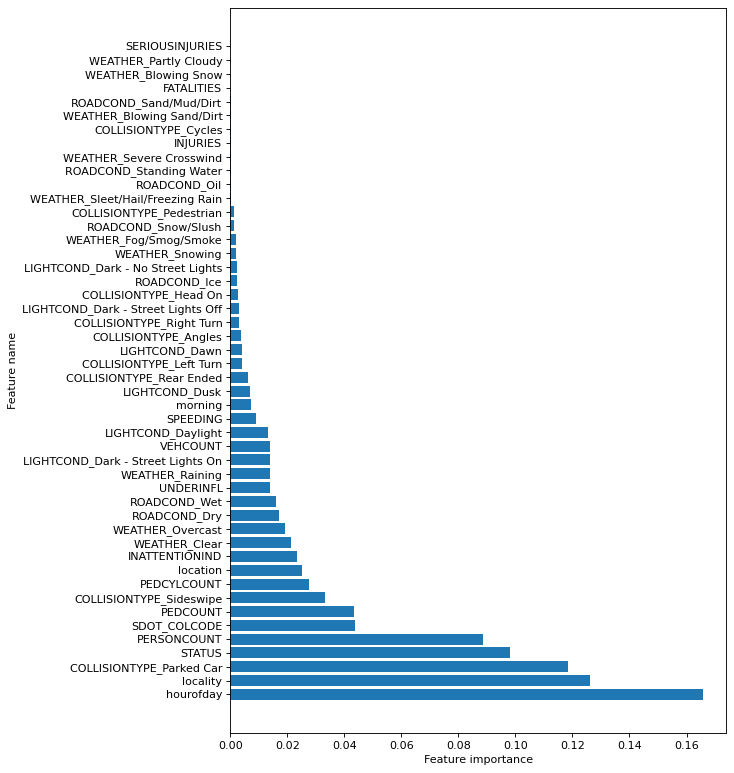

In [86]:
print('Features.size:', len(short_listed_opt))
plt.figure(figsize=(8, 12), dpi=80)
plot_feature_importances(feature_importances[indices], sorted_features)
plt.show()

#### List the sorted features according to their importances:

In [87]:
importances_df = pd.DataFrame(data=feature_importances[indices], index=sorted_features, columns=['Importance'])
#print('Feature importances: {}'.format(feature_importances[indices]))

num_features_selected = feature_set_limit # based on the importances plotted
#importances_df.iloc[:num_features_selected]

#### Note the number of features selected:

In [88]:
selected_features = importances_df.iloc[:num_features_selected]
selected_features.index

Index(['hourofday', 'locality', 'COLLISIONTYPE_Parked Car', 'STATUS',
       'PERSONCOUNT', 'SDOT_COLCODE', 'PEDCOUNT', 'COLLISIONTYPE_Sideswipe',
       'PEDCYLCOUNT', 'location', 'INATTENTIONIND', 'WEATHER_Clear',
       'WEATHER_Overcast', 'ROADCOND_Dry', 'ROADCOND_Wet', 'UNDERINFL',
       'WEATHER_Raining', 'LIGHTCOND_Dark - Street Lights On', 'VEHCOUNT',
       'LIGHTCOND_Daylight', 'SPEEDING', 'morning', 'LIGHTCOND_Dusk',
       'COLLISIONTYPE_Rear Ended'],
      dtype='object')

### Attempt dimentionality reduction using PCA:

In [89]:
if (do_dimensionality_reduction):
    n_components = 2 # keep numbers of features low or lower
    pca = SparsePCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X = X_pca # may comment this out if ...

X[0:5]

array([[-1.13972734, -0.22319148],
       [ 1.18476374,  1.24936914],
       [ 0.3821428 , -3.04648915],
       [ 0.18993156,  0.32430691],
       [-0.02593609,  1.5731429 ]])

#### Plot the outcome of dimensionality reduction

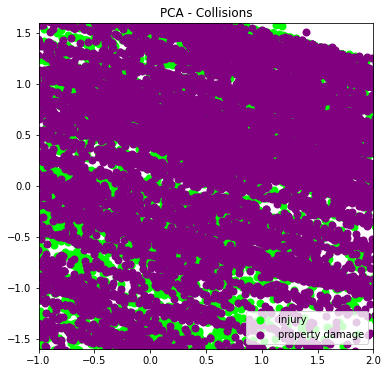

In [90]:
if (do_dimensionality_reduction):
    colors = ['lime', 'purple']
    target_names = ['injury', 'property damage']
    plt.figure(figsize=(6, 6))
    #plot the top two latent features
    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, lw=2, label=target_name)

    plt.title('PCA - Collisions')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.axis([-1, 2, -1.6, 1.6])
    plt.show()

# Model Development and Classification

A training set is used to build a accurate model, based on a set of classifiers. A test set is used to evaluate the accuracy of classifiers. Thereafter, the best classifier model is selected.

The following candidate classifier algorithms are evaluated:
- K Nearest Neighbor(KNN) (*typically, simple and expected to do a good jobs*)
- Decision Tree (DT)
- Gradient Boosted Decision Trees (GBDT) (*using an ensemble of classifiers*)

### Prepare the Training and Test Sets

In [91]:
test_prop = 0.25 # proportion of data set reserved for evaluation or testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=0)
print ('Train set (training models):', X_train.shape,  y_train.shape)
print ('Test set (evaluating models):', X_test.shape,  y_test.shape)

Train set (training models): (82320, 2) (82320,)
Test set (evaluating models): (27440, 2) (27440,)


### Set up how the models will be evaluated (using cross-validation):

For Evaluating the Models:<br/>
*First, review the list of possible evaluation scorers*

In [92]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

# K Nearest Neighbor (KNN)

The best accuracy was 0.6743804664723032 with k= 11


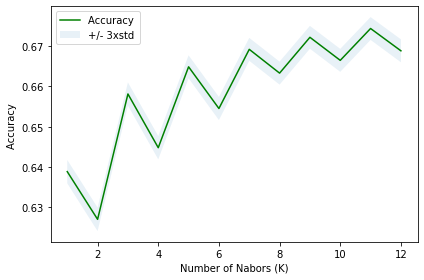

In [93]:
# Calculate the accuracy of KNN for different Ks
Ks = 13
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = np.mean(y_test == yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
# Plot model accuracy for different number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [94]:
# Finally, train Model using the best k
k = 11 # optimal k from above
knn_model = KNeighborsClassifier(n_neighbors = k)
knn_model

KNeighborsClassifier(n_neighbors=11)

In [95]:
# Evaluate model: precision, recall, and F-measure
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
performance = precision_recall_fscore_support(y_test, y_pred)
print('Precision', performance[0][0])
print('Recall', performance[1][0])
print('F1', performance[2][0])

Precision 0.6868901479383066
Recall 0.6378516624040921
F1 0.6614632667752813


# Decision Tree (DT)

The best accuracy was 0.6668367346938775 with max_depth = 18


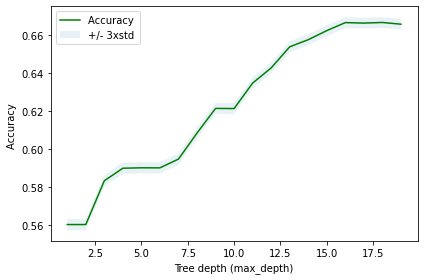

In [96]:
# Calculate the accuracy of tree classifier for different depths
tree_depths = 20
mean_acc = np.zeros((tree_depths-1))
std_acc = np.zeros((tree_depths-1))
for n in range(1,tree_depths):
    #Train Model and Predict
    tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    tree_classifier.fit(X_train,y_train)
    yhat=tree_classifier.predict(X_test)
    mean_acc[n-1] = np.mean(y_test == yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "The best accuracy was", mean_acc.max(), "with max_depth =", mean_acc.argmax()+1) 
# Plot model accuracy for different tree depths
plt.plot(range(1,tree_depths),mean_acc,'g')
plt.fill_between(range(1,tree_depths),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Tree depth (max_depth)')
plt.tight_layout()
plt.show()

In [119]:
# Train Model and Predict
tree_depths = 18 # optimal depth from above
tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = tree_depths)
tree_model

DecisionTreeClassifier(criterion='entropy', max_depth=18)

In [120]:
# Evaluate model: precision, recall, and F-measure
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
performance = precision_recall_fscore_support(y_test, y_pred)
print('Precision', performance[0][0])
print('Recall', performance[1][0])
print('F1', performance[2][0])

Precision 0.6907778803390114
Recall 0.6015345268542199
F1 0.6430747597843918


# Gradient Boosted Decision Trees (GBDT)

The best accuracy was 0.6678206997084548 with n_estimators = 300


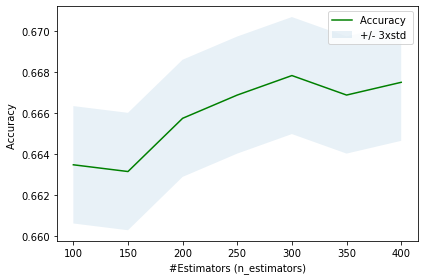

In [116]:
# Calculate the accuracy of GBDT for different n_estimators
start = 100
stop = 401
step = 50 # based on the setup above
n_estimators = range(start, stop, step) # e.g. [25, 50, 75, 100]
max_depth = 5 # leveraging from DT analysis above
learning_rate = 0.20
random_state = 0 # ensure repeatable
mean_acc = np.zeros(len(n_estimators))
std_acc = np.zeros(len(n_estimators))
for c, this_estimators in enumerate(n_estimators):
    gb_classifier = GradientBoostingClassifier(n_estimators=this_estimators, max_depth=max_depth, \
                                                 learning_rate=learning_rate, random_state=random_state)
    gb_classifier.fit(X_train, y_train)
    yhat = gb_classifier.predict(X_test)
    mean_acc[c] = np.mean(y_test == yhat)
    std_acc[c] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print( "The best accuracy was", mean_acc.max(), "with n_estimators =", n_estimators[mean_acc.argmax()]) 
# Plot model accuracy for different n_estimators
plt.plot(range(start, stop, step), mean_acc,'g')
plt.fill_between(range(start, stop, step), mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('#Estimators (n_estimators)')
plt.tight_layout()
plt.show()

In [117]:
# Finally, train Model using the best parameters
n_estimators = 300
max_depth = 5 # leveraging from DT analysis above
learning_rate = 0.20
random_state = 0 # ensure repeatable
gbdt_model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, \
                                                 learning_rate=learning_rate, random_state=random_state)
gbdt_model

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=300,
                           random_state=0)

In [118]:
# Evaluate model: precision, recall, and F-measure
gbdt_model.fit(X_train, y_train)
y_pred = gbdt_model.predict(X_test)
performance = precision_recall_fscore_support(y_test, y_pred)
print('Precision', performance[0][0])
print('Recall', performance[1][0])
print('F1', performance[2][0])

Precision 0.6888741940816664
Recall 0.6089879430032883
F1 0.6464724818678974


# Final Model Testing
Test the developed models using the selected features from the final test dataset

In [102]:
X_final = X_whole_test[selected_features.index]
X_final[0:1]

,hourofday,locality,COLLISIONTYPE_Parked Car,STATUS,PERSONCOUNT,SDOT_COLCODE,PEDCOUNT,COLLISIONTYPE_Sideswipe,PEDCYLCOUNT,location,...,ROADCOND_Wet,UNDERINFL,WEATHER_Raining,LIGHTCOND_Dark - Street Lights On,VEHCOUNT,LIGHTCOND_Daylight,SPEEDING,morning,LIGHTCOND_Dusk,COLLISIONTYPE_Rear Ended
12419,0,4,0,0,6,14.0,0,0,0,1,...,0,0,0,0,3,1,0,0,0,1


## Data Normalization of Test Phase Dataset
Normalize the test phase features - in this case, scale is not a huge problem but we do it for completeness.

In [103]:
from sklearn.preprocessing import StandardScaler
X_final = StandardScaler().fit_transform(X_final)
X_final[0:1]

array([[-1.460026  , -0.54907737, -0.45279053, -0.2941145 ,  2.76883565,
         0.09957239, -0.25195434, -0.27388139, -0.21917216,  0.69263116,
        -0.4234017 ,  0.89495534, -0.39734713,  0.78118217, -0.55322803,
        -0.23064077, -0.44487941, -0.54538684,  1.61843624,  0.83187071,
        -0.22506604, -0.94384994, -0.16857413,  2.10477979]])

### Conduct dimensionality reduction and then test the classifiers using the final data set set aside earlier.

In [104]:
if (do_dimensionality_reduction):
    n_components = 2 # keep numbers of features low or lower
    pca = SparsePCA(n_components=n_components)
    X_pca_test = pca.fit_transform(X_final)
    X_final_test = X_pca_test # may comment this out if ...
    
X_final_test[0:5]

array([[-1.18657066,  1.44030809],
       [-1.46814638,  0.56806648],
       [-0.2105307 ,  0.65482317],
       [ 3.90087936,  1.44101381],
       [-0.23119713,  0.64982142]])

In [105]:
# KNN
k = 11 # optimal k from above
knn_model = KNeighborsClassifier(n_neighbors = k)
# DT
tree_depths = 18 # optimal depth from above
tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = tree_depths)
# GBDT
n_estimators = 300
max_depth = 5 # leveraging from DT analysis above
learning_rate = 0.1
random_state = 0 # ensure repeatable
gbdt_model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, \
                                                 learning_rate=learning_rate, random_state=random_state)

In [106]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(knn_model, X_final_test, y_whole_test, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(knn_model, X_final_test, y_whole_test, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(knn_model, X_final_test, y_whole_test, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(knn_model, X_final_test, y_whole_test, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(knn_model, X_final_test, y_whole_test, cv=5, scoring = 'f1')))

Cross-validation (accuracy) 0.6468505971944964
Cross-validation (AUC) 0.7073745980581958
Cross-validation (recall) 0.6923067893824196
Cross-validation (precision) 0.6479458237549308
Cross-validation (f1) 0.6631227568186964


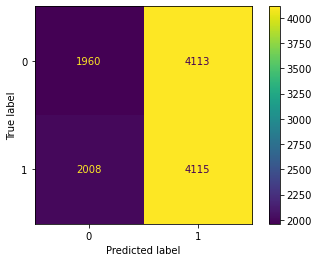

In [107]:
plot_confusion_matrix(knn_model.fit(X_train, y_train), X_final_test, y_whole_test)
plt.show()

In [108]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(tree_model, X_final_test, y_whole_test, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(tree_model, X_final_test, y_whole_test, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(tree_model, X_final_test, y_whole_test, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(tree_model, X_final_test, y_whole_test, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(tree_model, X_final_test, y_whole_test, cv=5, scoring = 'f1')))

Cross-validation (accuracy) 0.6222520987504957
Cross-validation (AUC) 0.6536391278598296
Cross-validation (recall) 0.6511535280778978
Cross-validation (precision) 0.6218245109515173
Cross-validation (f1) 0.6326901268598087


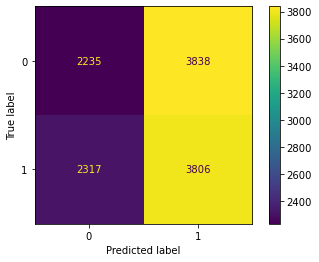

In [109]:
plot_confusion_matrix(tree_model.fit(X_train, y_train), X_final_test, y_whole_test)
plt.show()

In [110]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(gbdt_model, X_final_test, y_whole_test, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(gbdt_model, X_final_test, y_whole_test, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(gbdt_model, X_final_test, y_whole_test, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(gbdt_model, X_final_test, y_whole_test, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(gbdt_model, X_final_test, y_whole_test, cv=5, scoring = 'f1')))

Cross-validation (accuracy) 0.6325840676439551
Cross-validation (AUC) 0.6932369221879886
Cross-validation (recall) 0.6895338135254102
Cross-validation (precision) 0.634175894031701
Cross-validation (f1) 0.6532749761336245


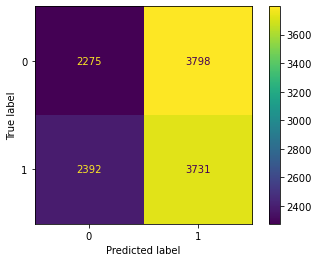

In [111]:
plot_confusion_matrix(gbdt_model.fit(X_train, y_train), X_final_test, y_whole_test)
plt.show()